# Multiscale Equation Free Projective Integration

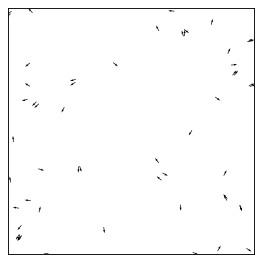

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""
Create Your Own Active Matter Simulation (With Python)
Philip Mocz (2021) Princeton Univeristy, @PMocz

Simulate Viscek model for flocking birds

"""



def main():
	""" Finite Volume simulation """
	
	# Simulation parameters
	v0           = 0.5      # velocity
	eta          = 0.5      # random fluctuation in angle (in radians)
	L            = 100       # size of box
	R            = 1        # interaction radius
	dt           = 1      # time step
	Nt           = 200      # number of time steps
	N            = 500      # number of birds
	plotRealTime = False
	
	# Initialize
	np.random.seed(17)      # set the random number generator seed

	# bird positions
	x = np.random.rand(N,1)*L
	y = np.random.rand(N,1)*L
	
	# bird velocities
	theta = 2 * np.pi * np.random.rand(N,1)
	vx = v0 * np.cos(theta)
	vy = v0 * np.sin(theta)
	
	# Prep figure
	fig = plt.figure(figsize=(4,4), dpi=80)
	ax = plt.gca()
	
	# store bird positions
	data = []
    
	# Simulation Main Loop
	for i in range(Nt):

		# move
		x += vx*dt
		y += vy*dt
		
		# apply periodic BCs
# 		x = x % L
# 		y = y % L
		
		# find mean angle of neighbors within R
		mean_theta = theta
		for b in range(N):
			neighbors = (x-x[b])**2+(y-y[b])**2 < R**2
			sx = np.sum(np.cos(theta[neighbors]))
			sy = np.sum(np.sin(theta[neighbors]))
			mean_theta[b] = np.arctan2(sy, sx)
			
		# add random perturbations
		theta = mean_theta + eta*(np.random.rand(N,1)-0.5)
		
		# update velocities
		vx = v0 * np.cos(theta)
		vy = v0 * np.sin(theta)
		
		# plot in real time
		if plotRealTime or (i == Nt-1):
			plt.cla()
			plt.quiver(x,y,vx,vy)
			ax.set(xlim=(0, L), ylim=(0, L))
			ax.set_aspect('equal')	
			ax.get_xaxis().set_visible(False)
			ax.get_yaxis().set_visible(False)
			plt.pause(0.001)
		data.append(np.hstack([x, y]))
				
	# Save figure
	# plt.savefig('activematter.png',dpi=240)
	plt.show()
	 
	return np.array(data)

data = main()

In [2]:
data.shape

(200, 500, 2)

In [3]:
means = np.mean(data, axis=1)

In [4]:
x, y = zip(*means)
means.shape

(200, 2)

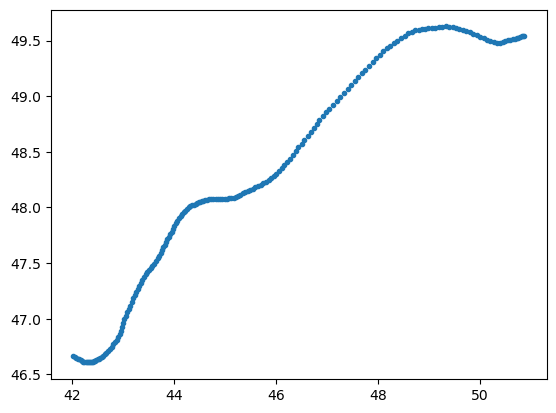

In [5]:
plt.plot(x, y, ".")
# plt.scatter(x, y, alpha=0.5)

In [6]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm


In [7]:
gmm100 = GaussianMixture(n_components=100)
gmm50 = GaussianMixture(n_components=50)
gmm20 = GaussianMixture(n_components=20)
gmm10 = GaussianMixture(n_components=10)
gmm5 = GaussianMixture(n_components=5)
gmm1 = GaussianMixture(n_components=1)

gmm100.fit(data[10])
gmm50.fit(data[10])
gmm20.fit(data[10])
gmm10.fit(data[10])
gmm5.fit(data[10])
gmm1.fit(data[10])

GaussianMixture()

[[77.15180795 68.39168015]
 [19.79065867 46.28572226]
 [69.40775339 29.48356675]
 [25.37909997 79.21571847]
 [29.21405751 10.51509673]]


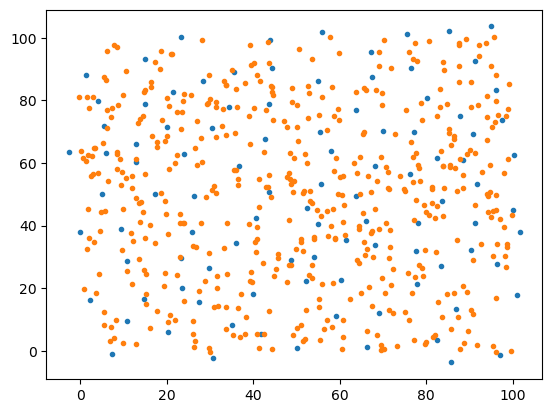

In [8]:
x, y = zip(*gmm100.means_)
plt.plot(x, y, '.')
x, y = zip(*data[0])
plt.plot(x, y, '.')
print(gmm5.means_)

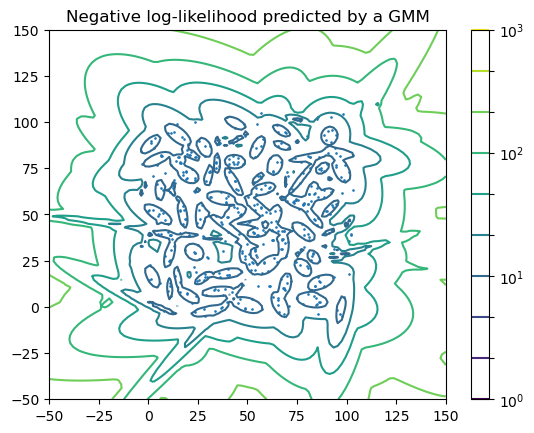

In [9]:
def draw_gmm(gmm, data):
    """
    plot the gmm on a grid along with a chosen set of points
    """
    x = np.linspace(-50.0, 150.0, 100)
    y = np.linspace(-50.0, 150.0, 100)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    
    CS = plt.contour(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
    )
    CB = plt.colorbar(CS)
    plt.scatter(data[:, 0], data[:, 1], 0.8)
    
    plt.title("Negative log-likelihood predicted by a GMM")
    plt.axis("tight")
    plt.show()

draw_gmm(gmm100, data[10])

In [51]:
def compute_jacobian_and_hessenberg(f):
    # for five points

    # compute the first order partial derivatives
    del_f = (3*f[0]-16*f[1]+36*f[2]-48*f[3]+25*f[4])/(12)

    # compute the second order partial derivatives
    xxyy = (11*f[0]-56*f[1]+114*f[2]-104*f[3]+35*f[4])/(12)
    f_xx = xxyy[0]
    f_yy = xxyy[1]

    
    f_xxx = (3*f[0]-14*f[1]+24*f[2]-18*f[3]+5*f[4])/(2)
    
def projective_step(f):
    # for five points, compute the finite difference estimates of various derivatives
    f_x = (3*f[0]-16*f[1]+36*f[2]-48*f[3]+25*f[4])/(12)
    f_xx = (11*f[0]-56*f[1]+114*f[2]-104*f[3]+35*f[4])/(12)
    f_xxx = (3*f[0]-14*f[1]+24*f[2]-18*f[3]+5*f[4])/(2)
    f_xxxx = (1*f[0]-4*f[1]+6*f[2]-4*f[3]+1*f[4])/(1)

    
    
    # Use Taylor's Theorem to compute the next state. A linear approximation seems to work the best
    # f_x = (1*f[2]-4*f[3]+3*f[4])/(2)
    f_h = f[-1] + f_x #+ (f_xx)/2 + (f_xxx) / 6 + f_xxxx / 24

    return f_h


def inchworm(g, num_steps=5):
    """
    g: an array/list of five successive states
    num_steps: the number of points to project into the future

    description: Inchworm refers to the fact that we project into the future one state at a time. Using states 1-5, 
    we predict the 6, then using states 2-6, we predict 7, etc. This is more accurate than choosing a larger value of h in 
    the projective step and predicting the nth state in a single step.
    """
    path = []
    f = g.copy()
    for j in range(num_steps):
        f_h = projective_step(f)
        
        f[0] = f[1]
        f[1] = f[2]
        f[2] = f[3]
        f[3] = f[4]
        f[4] = f_h
        
        path.append(f_h)

    return path

In [55]:
test_data = data[:5].copy()
f = []
for d in test_data:
    gmm = GaussianMixture(n_components=1)
    gmm.fit(d)
    f.append(gmm.means_)
    # f.append(np.mean(d, axis=0))

f = np.vstack(f)
print(f.shape)
mean_path = inchworm(f, num_steps=5) #projective_step(f, h=5) inchworm(f, num_steps=50)

(5, 2)


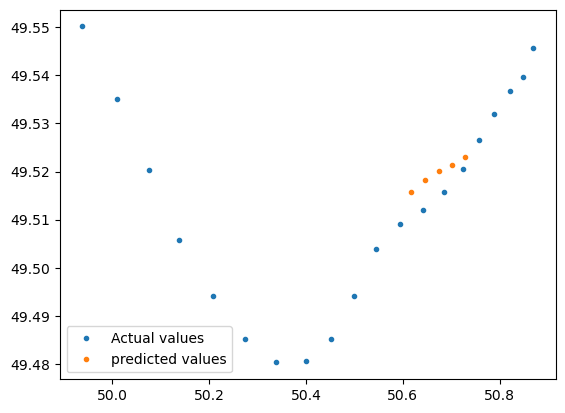

In [59]:

# plot the actual states
x, y = zip(*means[:20])
plt.plot(x, y, ".", label="Actual values")

# plot the predicted states
x, y, = zip(*mean_path)# mean_path[0], mean_path[1]
plt.plot(x, y, ".", label="predicted values")

plt.legend()
plt.show()

In [337]:
def multiscale_projective_integration(data, num_steps=20, tol=1e-3):
    
    # construct multiscale data
    multidata = {i:[] for i in range(3)}
    for d in data:
        # gmm100 = GaussianMixture(n_components=100)
        # gmm50 = GaussianMixture(n_components=50)
        # gmm20 = GaussianMixture(n_components=20)
        gmm10 = GaussianMixture(n_components=10)
        gmm5 = GaussianMixture(n_components=5)
        gmm1 = GaussianMixture(n_components=1)
        
        # gmm100.fit(d)
        # gmm50.fit(d)
        # gmm20.fit(d)
        gmm10.fit(d)
        gmm5.fit(d)
        gmm1.fit(d)

        multidata[0].append(gmm1.means_)
        multidata[1].append(gmm5.means_)
        multidata[2].append(gmm10.means_)

    # construct the projections
    multiproj = {}
    multiproj[0] = inchworm(multidata[0], num_steps=num_steps)
    multiproj[1] = inchworm(multidata[1], num_steps=num_steps)
    multiproj[2] = inchworm(multidata[2], num_steps=num_steps)

    five_to_one = []
    for step in multiproj[1]:
        gmm = GaussianMixture(n_components=1)
        gmm.fit(step)
        five_to_one.append(gmm.means_)
        
    cutoff = 0
    for i in range(num_steps):
        error = np.linalg.norm(five_to_one[i] - multiproj[0][i])
        if error > tol:
            cutoff = i
            print(error)
            print(i)
            print(multiproj[0][i])
            print(five_to_one[i])
            print(np.mean(multidata[1][1], axis=0))
            print(multidata[0][1])
            break
            
        

In [338]:
multiscale_projective_integration(test_data)

24.14519942993669
0
[[50.72873655 49.52295018]]
[[73.30276892 58.09054717]]
[50.17975835 47.67020369]
[[50.84764291 49.53959595]]


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
class LinearNetwork(nn.Module):
    def __init__(self, in_size, out_size, l1=128, l2=32):
        super().__init__()
        
        self.fc1 = nn.Linear(in_size, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, out_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        return self.fc3(x)

In [33]:
model = LinearNetwork(1000, 10)
macro_head = LinearNetwork(10, 2, l1=16, l2=16)
optimizer = optim.SGD(params=model.parameters(), lr=1e-3)
Loss = nn.MSELoss()

train_data = data[:150]
test_data = data[-50:]
# model.train()
# macro_head.train()

for _ in range(100):
    for i in range(len(train_data)-2):
        
        optimizer.zero_grad()
        x1 = train_data[i]
        x2 = train_data[i+1]
        x3 = train_data[i+2]
        
        x1 = x1.flatten()
        x1 = torch.tensor(x1)
        x2 = x2.flatten()
        x2 = torch.tensor(x2)
        x3 = x3.flatten()
        x3 = torch.tensor(x3)
        x = torch.vstack([x1, x2, x3]).type(torch.FloatTensor)
        y_hat = model(x)
        
        yh1 = y_hat[0]
        yh2 = y_hat[1]
        yh3 = y_hat[2]
        
        diff = yh2 - yh1
        yhh3 = yh2 + diff

        m1 = means[i]
        m2 = means[i+1]
        m3 = means[i+2]
        m = torch.tensor([m1, m2, m3]).type(torch.FloatTensor)

        yh = torch.vstack([yh1, yh2, yh3])
        mh = macro_head(yh)
        
        loss = Loss(yh3, yhh3)
        loss += Loss(m, mh)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(loss.item())
        
        

25.870622634887695
0.09670735150575638
0.8863232135772705
0.10994971543550491
0.09751636534929276
0.09780439734458923
0.14712457358837128
0.06082814186811447
0.30955255031585693
0.6494143605232239
0.18191185593605042
0.4710692763328552
0.16836699843406677
0.5391906499862671
0.13627231121063232
0.32219669222831726
0.1803978681564331
0.19764302670955658
0.23898659646511078
0.13783703744411469
0.3140074908733368
0.11791086196899414
0.4529329538345337
0.1049121767282486
0.5475471615791321
0.0970938429236412
0.5968272089958191
0.08805707842111588
0.6155309677124023
0.08074880391359329
0.5761052966117859
0.0676293596625328
0.520854115486145
0.06127098947763443
0.45164790749549866
0.051174283027648926
0.3950123190879822
0.04825916513800621
0.3200187385082245
0.042502835392951965
0.2585388422012329
0.039455197751522064
0.20176531374454498
0.03756285458803177
0.17686694860458374
0.029579605907201767
0.13399338722229004
0.027878977358341217
0.10879559814929962
0.02672499790787697
0.0862212479114

In [34]:
model.eval()
macro_head.eval()

test_means = means[-50:]

for i in range(len(test_data) - 2):
    x1 = test_data[i]
    x2 = test_data[i+1]
    x3 = test_data[i+2]

    x1 = x1.flatten()
    x1 = torch.tensor(x1)
    x2 = x2.flatten()
    x2 = torch.tensor(x2)
    x3 = x3.flatten()
    x3 = torch.tensor(x3)
    x = torch.vstack([x1, x2, x3]).type(torch.FloatTensor)

    y_hat = model(x)
    yh1 = y_hat[0]
    yh2 = y_hat[1]
    yh3 = y_hat[2]

    diff = yh2 - yh1
    yhh3 = yh2 + diff
    
    loss = Loss(yh3, yhh3)
    mh = macro_head(yh1)
    
    if i % 10 == 0:
        print(loss.item())
        print("diff: ", torch.norm(diff))
        
    if i % 10 == 0:
        print("-----")
        print(yh3)
        print(yhh3)
        print("Latent Norm: ", torch.norm(yh3))
        print("true marco state: ", means[i])
        print("pred macro state: ", mh)
    
        print("-----")

1.5687025785446167
diff:  tensor(3.6697, grad_fn=<CopyBackwards>)
-----
tensor([-166.6179,   -8.3229,   86.8795,   15.0881,   58.7491,  -74.7377,
         -21.8862,  -22.6177,  -39.9775,   13.9499], grad_fn=<SelectBackward0>)
tensor([-169.8617,   -8.2886,   88.0742,   15.5972,   59.7578,  -75.9611,
         -22.1435,  -23.3387,  -40.5316,   14.2141], grad_fn=<AddBackward0>)
Latent Norm:  tensor(217.7775, grad_fn=<CopyBackwards>)
true marco state:  [5.0577808  5.01476324]
pred macro state:  tensor([5.1855, 4.1192], grad_fn=<AddBackward0>)
-----
0.9174650311470032
diff:  tensor(3.0163, grad_fn=<CopyBackwards>)
-----
tensor([-168.5393,   -8.5457,   79.8169,   24.3150,   60.7367,  -71.3320,
         -14.5472,  -43.8227,  -41.9654,    4.7929], grad_fn=<SelectBackward0>)
tensor([-166.2478,   -8.4835,   78.7337,   23.9885,   59.7796,  -70.2945,
         -14.4006,  -43.3867,  -41.3213,    4.6480], grad_fn=<AddBackward0>)
Latent Norm:  tensor(219.3941, grad_fn=<CopyBackwards>)
true marco state: